# Object Detection on live video feed

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import cv2 #OpenCV

## Loading the video feed

In [11]:

# Load the video as a series of frames using the helper function in trainspotting.py
video_file = cv2.VideoCapture('/Volumes/Work2/work/python/projects/Motion detection/video1.MOV')

# Read iterates through the frames in the video object and returns:
# 1. Logical - True if a frame has been read
# 2. Image - an array with the current frame
read_file, frame = video_file.read()
original = []
while read_file:
    # Going to grab the frame and create a list for future use 
    original.append(frame)
    
    # Use imshow to play video
    cv2.imshow('Original video',frame)
    
    # Get next frame 
    read_file, frame = video_file.read()
    
    # Pause and allow for "q" button to stop video
    if cv2.waitKey(1) & 0xFF == ord('q'): 
        break

cv2.destroyWindow('Original video')

#for i in range (1,10):
#    cv2.waitKey(1)
#    cv2.waitKey(1)


## Operations on frames before detecting the object
### Smoothing the image for more generalized results
### Converting into gray scale and finding difference for motion detection
### Absolute difference(when the difference is more than some threshold) between the frames to detect motion

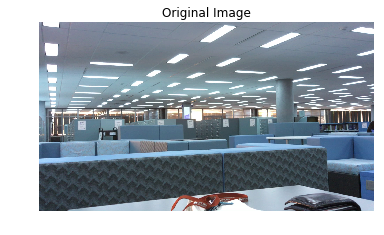

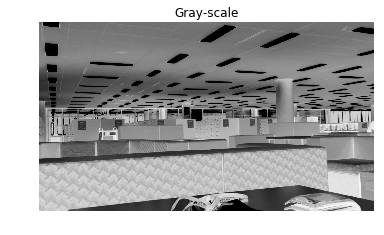

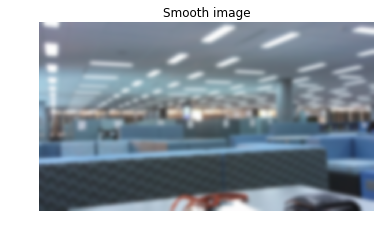

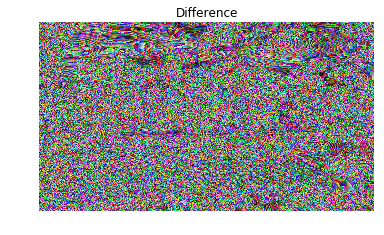

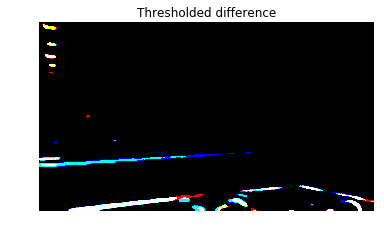

In [14]:
running_avg = None
alpha = 0.2
motion_thresh = 20 


for j, frame in enumerate(original):
    
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    smooth_frame = cv2.GaussianBlur(frame, (k,k), 0)
    
    if running_avg is None:
        running_avg = np.float32(smooth_frame) 
    
    diff = cv2.absdiff(np.float32(smooth_frame), np.float32(running_avg))
    cv2.accumulateWeighted(np.float32(smooth_frame), running_avg, alpha)
    
    _, subtracted = cv2.threshold(diff, motion_thresh, 1, cv2.THRESH_BINARY)
    

plt.imshow(frame, cmap='binary')
plt.axis('off')
plt.title('Original Image')
plt.show()
plt.imshow(gray_frame, cmap='binary')
plt.axis('off')
plt.title('Gray-scale')
plt.show()
plt.imshow(smooth_frame, cmap='binary')
plt.axis('off')
plt.title('Smooth image')
plt.show()
plt.imshow(diff, cmap='binary')
plt.axis('off')
plt.title('Difference')
plt.show()
plt.imshow(subtracted, cmap='binary')
plt.axis('off')
plt.title('Thresholded difference')
plt.show()

In [ ]:
# When the difference in frames is more than some threshold, only then we will say say there is some motion.

## After detecting motion, sending that frame to neural network for object detecton

object detected beginning at frame 96
Faces
object detected beginning at frame 106
Faces
object detected beginning at frame 116
Faces


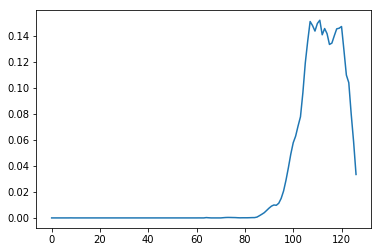

In [135]:
motion_fractions =[]

# Initialize dataframe to capture motion
history = pd.DataFrame(data=[[0,0]],columns=['Fraction','In_motion'])
# Define Minimum number of frames to be considered a train
history_length = 10
# Define minimum fraction of frame to be in motion to be 
# considered train style 
frame_thresh = 0.025

motion_thresh = 35 
alpha = 0.2
running_avg = None 
k = 31
for j, frame in enumerate(original):
    
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    smooth_frame = cv2.GaussianBlur(gray_frame, (k,k), 0)
    
    if running_avg is None:
        running_avg = np.float32(smooth_frame) 
    
    diff = cv2.absdiff(np.float32(smooth_frame), np.float32(running_avg))
    cv2.accumulateWeighted(np.float32(smooth_frame), running_avg, alpha)
    
    _, subtracted = cv2.threshold(diff, motion_thresh, 1, cv2.THRESH_BINARY)
    
    motion_fraction = (sum(sum(subtracted))/
                       (subtracted.shape[0]*subtracted.shape[1]))
    
    motion_fractions.append(motion_fraction)
    history.loc[len(history)+1] = [motion_fraction, motion_fraction>frame_thresh]
    
    detect = (history.tail(history_length).In_motion.sum()==history_length)
    
    if detect:
        print('object detected beginning at frame', j-history_length)
        image_to_classify = np.array([cv2.resize(frame,(256,256))])
        object_index = image_classification(image_to_classify)
        print(target_list[object_index])
        # Reset history
        history = pd.DataFrame(data=[[0,0]],columns=['Fraction','In_motion'])
    
plt.plot(motion_fractions)
plt.show()

In [ ]:
### Here you can see that object is detected after 96th frame and the value of threshhold difference increases.

## Loading the Pre-trained neural network

In [126]:
import tensorflow as tf

In [132]:
# items to be detected during live video stream
tf.reset_default_graph()
target_list = ['Faces',
 'camera',
 'car_side',
 'ceiling_fan',
 'chair',
 'cup',
 'electric_guitar',
 'laptop',
 'pizza',
 'umbrella']
sess = tf.Session()    
saver = tf.train.import_meta_graph('my_imageRecognition_model.meta')
saver.restore(sess,tf.train.latest_checkpoint('./'))
graph = tf.get_default_graph()
X = graph.get_tensor_by_name("inputs/X:0")
Y_proba = graph.get_tensor_by_name("output/Y_proba:0")



INFO:tensorflow:Restoring parameters from ./my_imageRecognition_model


### Function used to classify the object detected

In [ ]:
def image_classification(image_to_classify):
    
    feed_dict ={X:image_to_classify}
    object_array = sess.run(Y_proba,feed_dict)
    object_index = object_array.argmax()
    return object_index

### Code to visulize different operations on the video stream for detecting the object using your laptop webcam

In [ ]:
# Start streaming images from your computer camera
feed = cv2.VideoCapture(0) 

# Define the parameters needed for motion detection
alpha = 0.02 # Define weighting coefficient for running average
motion_thresh = 35 # Threshold for what difference in pixels  
running_avg = None # Initialize variable for running average

k = 31
while True:
    current_frame = feed.read()[1]
    gray_frame = cv2.cvtColor(current_frame, cv2.COLOR_BGR2GRAY)
    smooth_frame = cv2.GaussianBlur(gray_frame, (k, k), 0)

    # If this is the first frame, making running avg current frame
    if running_avg is None:
        running_avg = np.float32(smooth_frame) 

    # Find absolute difference between the current smoothed frame and the running average
    diff = cv2.absdiff(np.float32(smooth_frame), np.float32(running_avg))

    # Then add current frame to running average after
    cv2.accumulateWeighted(np.float32(smooth_frame), running_avg, alpha)

    # For all pixels with a difference > thresh, turn pixel to 255, otherwise 0
    _, subtracted = cv2.threshold(diff, motion_thresh, 1, cv2.THRESH_BINARY)

    cv2.imshow('Actual image', current_frame)
    cv2.imshow('Gray-scale', gray_frame)
    cv2.imshow('Smooth', smooth_frame)
    cv2.imshow('Difference', diff)
    cv2.imshow('Thresholded difference', subtracted)

    if cv2.waitKey(1) & 0xFF == ord('q'): 
        break
cv2.destroyAllWindows()
feed.release()